# DH-401: Digital Musicology semester project
---------------
## Predicting music popularity using DNNs - Milestone 3

### Table of Content

1. [Research Question](#rq)
1. [Popularity score](#pop)
1. [Features selection for regression](#feat-selection)
1. [Samples for questionnary](#survey)
1. [Survey analysis](#survey-analysis)
1. [Explaining the linear regression model of popularity score using audioLIME](#audiolime)
1. [Efforts to use Wave2Vec2.0 for popularity estimation](#wave2vec)

-------------------

### Reasearch Question <a class="anchor" id="rq"></a>

It's common in the history of music that some genres and bands gain very high popularity and some aren't noticed at all. It's not really easy to find out which piece will gain an universal acclaim. Or is it? Maybe the popularity of the most known music is the intrinsic feature of that music itself?

In this project, we want to answer the question: to what extent music popularity can be identified solely based on the musical features, and what are the features that make music popular ? Is it possible to identify musical features that play a significant role in songs' popularity ? It's interesting to see whether there are parameters and patterns which lead to the increased music popularity. Needless to say, that this kind of information is priceless for the whole music industry, and for the musicians themselves, as the music which is more popular will, by definition, reach a broader audience and have a higher chance of selling better. 


To conduct our study, we use the the [FMA: A Dataset for Music Analysis](https://arxiv.org/abs/1612.01840) dataset. It is publicly available on [Github](https://github.com/mdeff/fma) and the files are stored on UNIL/SWITCH server.


For this study, we are making two main assumptions :
1. We claim that popular music has a lot of listens. Let's explain that by starting from the definition of "popular music". According to Gaynor Jones and Jay Rahn, "an obvious criterion for a music's popularity is the number of people who experience it: the more people involved, the more popular music" *(Gaynor Jones and Jay Rahn (1977). Definitions of Popular Music: Recycled. The Journal of Aesthetic Education , Oct., 1977, Vol. 11, No. 4, pp. 79-92, [Jstor](https://www.jstor.org/stable/3332182).)*. That means that a music can be qualified as popular if it reaches  a wide audience. However, we shouldn't be too quick with the definition and acknowledge that popularity more complex than that, that "various groups of people cultivate certain genres within a popular idiom". (TODO same ref as above). This can be social class, geographical place, race, education, or other. We do not account for any of these in our study. We however try to make our analysis more fine-grained by studying popularity within genres, so that a music is popular if, within its genre, it has a lot of listens.


2. There would exist some intrinsic features of each music piece which participate in making it more or less popular than others. We mean by 'intrinsic features', features that are directly calculated from the audio sound wave - and its spectrogram. This approach inscribes our work in the still recent field of Hit Song Science (HSS) whose goal is to "understand better the relation between intrinsic characteristics of songs and their popularity, regardless of the complex and poorly understood mechanisms of human appreciation and social pressure" (Pachet, 2012). As a result of this project, we expect to identify several technical characteristics of the music which result in its success.


To answer the research question, we are first going to check our two assumptions. For assumption (1), we will conduct a survey in order to (TODO write goal of survey precisely). To check on assumption (2), we implement a Deep Neural Network to (TODO justify choice of DNN). After that, we are going to come up with a popularity metric based on the data available. It will take into accound the number of listens of the song, but also of the album and the number of likes and comments. Then we identify discriminating features in music, and apply regression models for musics in each genre to detect the features that play a role in popularity. Finally, the biggest challenge is how we can interpret the features and make sense of them, trying to create listenable interpretations of our model, to answer accuratly our research question.


Throughout this study, we will take particular care to pinpoint the limitations of each step that we take. (TODO write biggest limitations of our project : about the survey, about the model interpretation,...). 
   
    

Levels of popularity, against pop vs unpop :  Russel B. Nye, "Notes for an Introduction to a Discussion of Popular Culture, Journal of Popular Culture, Vol. 4 (Spring 1971):1031-38, on the need to recognize degrees of popularity

In [2]:
from zipfile import ZipFile
from tqdm.notebook import tqdm

from IPython import display

import librosa
#import soundfile as sf
#import torchaudio

import seaborn as sns
import pandas as pd
import numpy as np

import os
import ast

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from scipy.stats import chisquare
from scipy.stats import shapiro

from nltk import agreement

import matplotlib.pyplot as plt
from scipy.cluster import hierarchy as hc
from scipy import stats
from sklearn import preprocessing

#import torch
#import torch.nn as nn
#import torch.nn.functional as F

#from transformers import Wav2Vec2PreTrainedModel, Wav2Vec2Model, Wav2Vec2FeatureExtractor
#from transformers.modeling_outputs import SequenceClassifierOutput

#from torch.utils.data import DataLoader

#from audioLIME.data_provider import RawAudioProvider
#from audioLIME.factorization import SpleeterFactorization
#from audioLIME import lime_audio
#import spleeter

plt.rcParams['figure.figsize'] = (17, 5)

# You should have fma_large and fma_metadata updated in this directory for the code to run properly
datasource = "data"

In [3]:
# Load metadata and features.
# Function based on: https://github.com/mdeff/fma/blob/master/utils.py
tracks = pd.read_csv(f'{datasource}/fma_metadata/tracks.csv', index_col=0, header=[0, 1])

COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
            ('track', 'genres'), ('track', 'genres_all')]
for column in COLUMNS:
    tracks[column] = tracks[column].map(ast.literal_eval)

COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
            ('album', 'date_created'), ('album', 'date_released'),
            ('artist', 'date_created'), ('artist', 'active_year_begin'),
            ('artist', 'active_year_end')]
for column in COLUMNS:
    tracks[column] = pd.to_datetime(tracks[column])

SUBSETS = ('small', 'medium', 'large')
try:
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
            'category', categories=SUBSETS, ordered=True)
except (ValueError, TypeError):
    # the categories and ordered arguments were removed in pandas 0.25
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
              pd.CategoricalDtype(categories=SUBSETS, ordered=True))

COLUMNS = [('track', 'genre_top'), ('track', 'license'),
            ('album', 'type'), ('album', 'information'),
            ('artist', 'bio')]
for column in COLUMNS:
    tracks[column] = tracks[column].astype('category')


tracks.shape

(106574, 52)

## Popularity score  <a class="anchor" id="pop"></a>

To define popularity, we will use a score, instead of 'popular' or 'unpopular', as it is more accurate to talk about levels of popularity, rather than a binary classification. *(Russel B. Nye, "Notes for an Introduction to a Discussion of Popular Culture, Journal of Popular Culture, Vol. 4 (Spring 1971):1031-38, on the need to recognize degrees of popularity)*.


The dataset contains different measures that can be used to define popularity: number of listens, likes and comments. These features are present at two levels (song and album). The two levels come from Free Music Archive's API and both encompass important information concerning the dispersion of the songs. Thus, we first build a DataFrame containing all these scores for all of the songs available in the dataset.

### Popularity features <a class="anchor" id="pop-feat"></a>

In [4]:
POP_FEATURES = ["listens", "favorites", "comments"]

In [5]:
pop_df = tracks["track"][["date_created", "genre_top"]+POP_FEATURES]

# add informations collected at the "album level"
for pop_feat in POP_FEATURES:
    pop_df["album_"+pop_feat] = [count for count in tracks["album"][pop_feat]]

pop_df.sample(3)

date_created   genre_top  listens  favorites  comments  \
track_id                                                                 
146396   2016-11-14 08:24:51         NaN      166          0         0   
9107     2009-03-30 16:32:21  Electronic      713          2         0   
72106    2012-10-30 17:55:32         NaN     2575          4         0   

          album_listens  album_favorites  album_comments  
track_id                                                  
146396            70247                0               0  
9107              97866                4               0  
72106             46735                2               1

The number of listens per song and per album reflect different realities, in that they are not directly based on one another (the number of listens of an album is not the sum of the number of listens of its songs and the number of listens of the songs don't take into account the number of listens of the album). In other words, if $l_s$ is the number of listens of a song, $a$ refers to albums and $\{s\in a\}$ the set of songs in one album, $$ \sum_{s\in a}l_s \neq l_a $$

This fact is illustrated below and two extreme examples are underlined.

In [6]:
# build a DataFrame of albums
albums = tracks["album"].groupby(["id"]).mean()[["listens"]]
# remove songs without album
albums = albums[albums.listens > 0]

albums["sum_songs"] = 0
albums["album"] = 0
albums["songs_minus_album"] = 0
albums["songs_ratio_album"] = 0

for alb_id, _ in tqdm(albums.iterrows(), total=albums.shape[0]):
    # retrieve track ids for the album
    curr_track_ids = tracks["album"][tracks["album"].id == alb_id].index.values
    # compute sum of the listens of the album's songs
    curr_sum_songs_listens = pop_df.loc[curr_track_ids].listens.sum()
    # retrieve album's number of listens
    curr_album_listens = pop_df.loc[curr_track_ids].album_listens.iloc[0]
    
    # add these information to the `albums` DataFrame
    albums.loc[alb_id, "sum_songs"] = curr_sum_songs_listens
    albums.loc[alb_id, "album"] = curr_album_listens
    # compute difference and ratio
    albums.loc[alb_id, "songs_minus_album"] = curr_sum_songs_listens-curr_album_listens
    albums.loc[alb_id, "songs_ratio_album"] = curr_sum_songs_listens/curr_album_listens
    
albums = albums.sort_values(by="songs_minus_album")

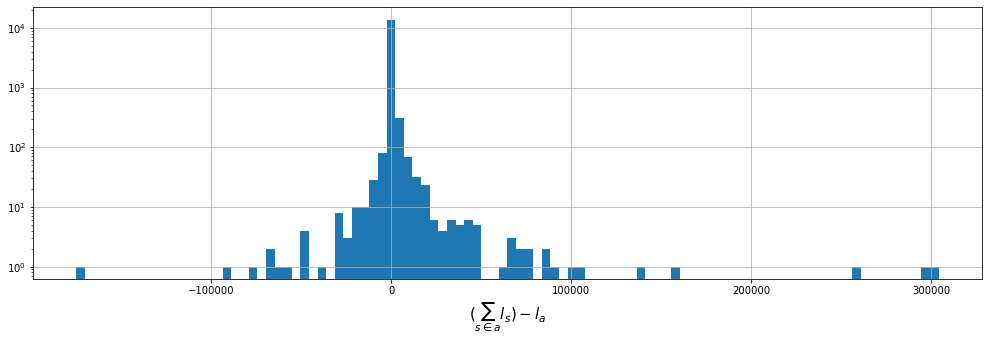

In [7]:
# histogram of the sum of album's songs' listens - album's listens
albums["songs_minus_album"].hist(bins=100)
plt.xlabel(r"$(\sum_{s\in a}l_s) - l_a$", fontsize=15)
plt.semilogy()
plt.show()

In [8]:
id_album = albums["songs_minus_album"].idxmin() #10953

id_tracks = tracks["album"][tracks["album"].id == id_album].index.values

print("The album '{album_title}' containing {n_songs} song{plural} was listened {alb_listens} times as an album, \
but individually the song{plural} account{sing} for {more_or_less} listens: {songs_sum_listens}."\
      .format(album_title=tracks["album"].loc[id_tracks].iloc[0].title
              , n_songs=len(id_tracks)
              , plural='s' if len(id_tracks)>1 else ''
              , sing='' if len(id_tracks)>1 else 's'
              , alb_listens=pop_df.loc[id_tracks].iloc[0].album_listens
              , songs_sum_listens=np.sum(pop_df.loc[id_tracks].listens)
              , more_or_less='more' 
              if (np.sum(pop_df.loc[id_tracks].listens)/pop_df.loc[id_tracks].iloc[0].album_listens)>1 
              else 'less'
             )
     )

The album 'Music For Media Vol. 3' containing 8 songs was listened 247274 times as an album, but individually the songs account for less listens: 72202.


In [9]:
id_album = albums["songs_minus_album"].idxmax() #7690

id_tracks = tracks["album"][tracks["album"].id == id_album].index.values

print("The album '{album_title}' containing {n_songs} song{plural} was listened {alb_listens} times as an album, \
but individually the song{plural} account{sing} for {more_or_less} listens: {songs_sum_listens}."\
      .format(album_title=tracks["album"].loc[id_tracks].iloc[0].title
              , n_songs=len(id_tracks)
              , plural='s' if len(id_tracks)>1 else ''
              , sing='' if len(id_tracks)>1 else 's'
              , alb_listens=pop_df.loc[id_tracks].iloc[0].album_listens
              , songs_sum_listens=np.sum(pop_df.loc[id_tracks].listens)
              , more_or_less='more' 
              if (np.sum(pop_df.loc[id_tracks].listens)/pop_df.loc[id_tracks].iloc[0].album_listens)>1 
              else 'less'
             )
     )

The album '...Plays Guitar' containing 7 songs was listened 386403 times as an album, but individually the songs account for more listens: 690479.


### Removing songs without album <a class="anchor" id="pop-remove"></a>

The number of listens, likes and comments of albums bring supplementary, non negligible, information about the public a song could have reached. However some songs don't appear in albums (reflected by $-1$ for album listens, comments, and favorites counts in the DataFrame). These songs represent appproximately 3.3% of the dataset, so they are left aside to be able to compute a more coherent popularity score based on both of the disposable levels.

In [10]:
# songs without albums have -1 as count for listens, favorites, comments
no_album = pop_df.album_listens < 0
print("{0:.2f}% songs have no album.".format(100*np.sum(no_album)/len(pop_df)))

3.31% songs have no album.


In [11]:
# keeping only songs with album informations
pop_df = pop_df[~no_album].copy()
pop_df.shape

(103045, 8)

The distribution of the logarithmic transform of the different features are plotted below, showing that they reflect different realities and justifying that the album level should not be neglected, as it appears to be largely used by FMA's users.

In [12]:
def log_transform(serie):
    """log transform for serie of non-negative values"""
    return np.log((serie)+1)

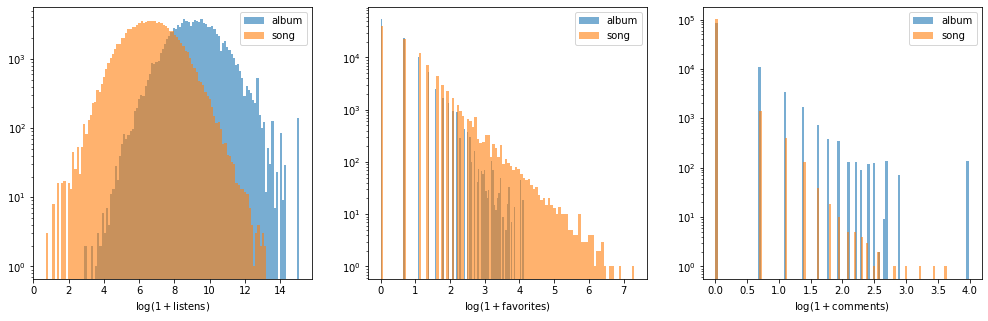

In [13]:
f, axes = plt.subplots(nrows=1,ncols=3, sharex=False)

for ax, feat in zip(axes, POP_FEATURES) :
    ax.hist(log_transform(pop_df["album_"+feat]), bins=100, alpha=0.6, label="album")
    ax.hist(log_transform(pop_df[feat]), bins=100, alpha=0.6, label="song")
    ax.set_xlabel(r"$\log(1+$"+feat+"$)$")
    ax.legend()
    ax.semilogy()
plt.legend()
plt.show()

### Computing popularity scores <a class="anchor" id="pop-scores"></a>

The popularity score can then be computed as the one-dimensional projection of the logarithmic transformation of these features using PCA to encompass the maximum informations of these different dimensions in a single value per song.

This popularity score can then be thought of as a proxy of the ability of a song to reach a great audience. The number of likes and comments add informations about the engagement of publics towards the songs.
It could potentially embrace social dynamics, an hypothesis could be that users that have liked or commented a song are more prone to recommend or play this song to their entourage, thus spreading the song.

In [14]:
# without `interest` but with album scores
X = pop_df[POP_FEATURES+["album_"+pop_feat for pop_feat in POP_FEATURES]].copy()

for pop_feat in X.columns:
    # using log transform for the pca
    X[pop_feat] = log_transform(X[pop_feat])

pca = PCA(n_components=1, svd_solver="full").fit(X)
#computing popularity score as a 1D projection of the popularity features
pop_df["pop_score"] = pca.transform(X) 

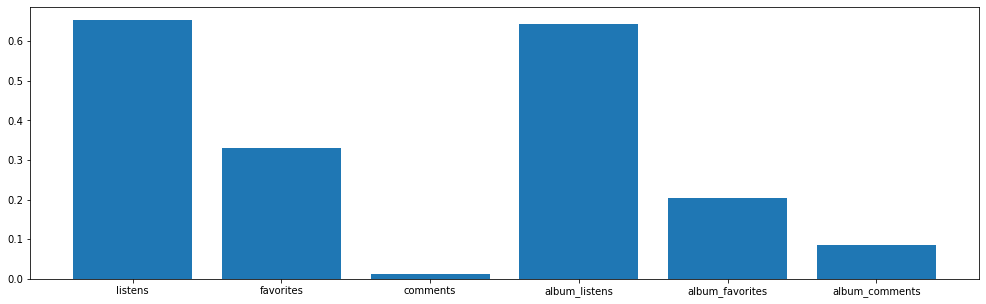

In [15]:
# display the weight of each component in the projection
plt.bar(X.columns
        , (pca.components_)[0]
       )
plt.show()

/Users/nmm/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


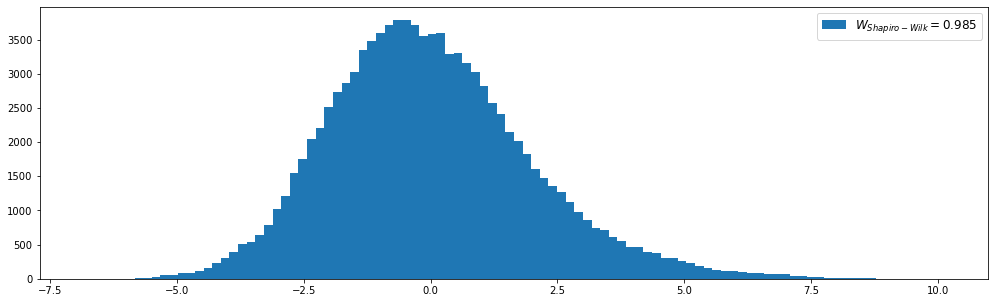

In [16]:
# plot the distribution of the 1D-popularity projection, and showcase its Shapiro-Wilk score
W, p_val = shapiro(pop_df.pop_score)

plt.hist(pop_df.pop_score, bins=100, label=r"$W_{Shapiro-Wilk}"+"={0:.3f}$".format(W))
plt.legend(fontsize=12)
plt.show()

In [17]:
# as the distribution is ~ normal (shapiro close to 1), standardize the score (z-score normalization)
pop_df["pop_score"] = (pop_df["pop_score"]-np.mean(pop_df["pop_score"]))/(np.std(pop_df["pop_score"]))

In [18]:
pop_df.sample(3)

date_created  genre_top  listens  favorites  comments  \
track_id                                                                
50485    2011-07-07 05:31:27        NaN     1256          7         0   
65658    2012-05-29 17:07:05  Classical     1738          5         0   
50888    2011-07-15 11:29:34      Blues   143301         98         0   

          album_listens  album_favorites  album_comments  pop_score  
track_id                                                             
50485              1254                2               0  -0.252842  
65658            109165               14               2   1.461825  
50888            415275               14               2   3.809135

## Generate samples for finetuning

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pop_df.pop_score, test_size=0.05)
train.to_csv("train.csv")
test.to_csv("test.csv")

## Feature selection for regressions <a class="anchor" id="feat-selection"></a>

Correlation for each feature

In [20]:
features = pd.read_csv(f'{datasource}/fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
features.sample(3)

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
126151       -0.629301 -0.176407  0.146989  0.356752 -0.979460 -0.303307   
64539         2.688715  3.575746 -0.684809  0.253194 -0.397491  0.438119   
149118       -0.102926  0.687953 -0.149408  0.582082  0.404237  1.513442   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
126151     -0.912425 -0.603406  0.257387 -0.386984  ...  0.085416  0.021778   
64539       1.416026  1.685018  2.500334  2.359813  ...  0.095469  0.019939   
149118      0.258032 -0.385113 -0.549277  0.338091  ...  0.086130  0.019288   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
126151      0.016968  33.421562  0.334961  0.025335  0.016602  0.002441   
64539       0.018433  14.148462  0.310547  0.026121  0.016602  0.001465   
149118      0.020200   4.037624  0.296875  0.047870  0.039062  0.000000   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
126151      5.028231  0.028425  
64539       3.132650  0.028275  
149118      1.608805  0.034597  

[3 rows x 518 columns]

In [19]:
corr_matrix = features.corr()

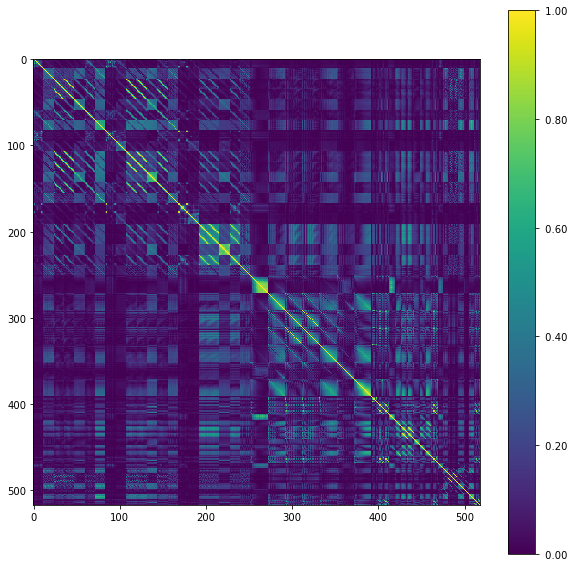

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(corr_matrix.abs())
im.set_clim(0, 1)
ax.grid(False)
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

Code from https://gist.github.com/MattJBritton/b6944218903312f6220bfb48706b593c#file-minimal_example-py

In [21]:
def visualize_feature_correlation(data, chart_type, target_name = None, cluster_scope = None, user_defined_clusters = None):
    df = data.copy()
    corr = np.round(df.corr(),2)
    if target_name is not None:
        target_corr = np.abs(corr.rename({target_name:"target_corr"}, axis=1)["target_corr"])
        df = df.drop(target_name, axis=1)
        corr = corr.drop(target_name, axis=1).drop(target_name, axis=0)
    default_feature_order = sorted(list(df.columns))
    corr_condensed = hc.distance.squareform(1 - np.abs(df.corr()) ) # convert to condensed
    z = hc.linkage(corr_condensed, method='average');
    feature_order = hc.dendrogram(z, labels=df.columns, no_plot=True)["ivl"];  
    if chart_type == "dendrogram":    
        fig = ff.create_dendrogram(
            1 - np.abs(corr), 
            labels = df.columns
        )
        fig.update_layout(width=800, height=500)
        fig.show()
    elif chart_type == "punchcard":
        heatmap_data = corr.reset_index(drop = False).melt(id_vars="index")
        base = alt.Chart(
            heatmap_data
        ).encode(
            x = alt.X("index", sort = feature_order, axis=None),
            y = alt.Y("variable", sort = feature_order, axis=None)
        ).transform_calculate(
            abs_val = 'abs(datum.value)',
            positive_corr = 'datum.value > 0'
        ).transform_lookup(
            lookup='index',
            from_=alt.LookupData(
                data=pd.DataFrame(feature_order).reset_index(drop=False).rename({"index":"order_X", 0:"feature"}, axis=1),
                key='feature',
                fields=['order_X']
            )
        ).transform_lookup(
            lookup='variable',
            from_=alt.LookupData(
                data=pd.DataFrame(feature_order).reset_index(drop=False).rename({"index":"order_Y", 0:"feature"}, axis=1),
                key='feature',
                fields=['order_Y']
            )
        ).properties(
            width = 700,
            height = 500
        )

        circles = base.mark_circle().encode(
            color = "positive_corr:N",
            size = alt.condition(
                "datum.order_Y >= datum.order_X",
                alt.value(0),
                alt.Size(
                    "abs_val:Q", 
                    scale=alt.Scale(range=[0,1000], domain=[0,1])
                )
            )
        )
        text = base.mark_text(align="right").encode(
            text = "index",
            opacity = alt.condition("datum.order_Y == datum.order_X", alt.value(1), alt.value(0))
        )
        return (text+circles).resolve_scale(y = "shared", x="shared")
    elif chart_type == "heatmap":
        heatmap_data = corr.reset_index(drop = False).melt(id_vars="index")
        base = alt.Chart(
            heatmap_data
        ).encode(
            x = alt.X("index", sort = feature_order, axis = alt.Axis(labelAngle=15)),
            y = alt.Y("variable", sort = feature_order)
        ).transform_calculate(
            abs_val = 'abs(datum.value)'
        ).properties(
            width = 600,
            height = 600
        )

        rects = base.mark_rect().encode(
            color = alt.Color("abs_val:Q", scale=alt.Scale(domain=[0,1])),
        )
        text = base.mark_text(align="center").encode(
            text = "value",
            color = alt.condition(
                "datum.value < .5",
                alt.value("black"),
                alt.value("white")
            )
        )
        return (rects+text).resolve_scale(y = "shared", x="shared")
    elif chart_type == "clusters":
        
        sidebar_width = 200
        sidebar_component_height = 75
        
        #compute PCA and store as X,Y coordinates for each feature
        pca = PCA(n_components = 2)
        pca.fit(np.abs(corr))
        pca_coords = pd.DataFrame.from_dict(
            dict(
                zip(
                    list(df.columns),
                    pca.transform(np.abs(corr)).tolist()
                )
            ),
            orient="index"
        ).reset_index().rename({0:"X", 1:"Y", "index":"feature"}, axis=1)
        
        

        if user_defined_clusters:
            
            num_labels = np.unique(user_defined_clusters.values()).shape[0]
            silhouette_scores = [
                {
                    "cluster_num": num_labels, 
                    "silhouette_score": 1, 
                    "feature": col,
                    "cluster": user_defined_clusters[col]
                }
                for col in df.columns
            ]
        else:
        
            #get feature clusters via another method
            scaler = StandardScaler()
            feature_distances = squareform(pdist(scaler.fit_transform(df).T, "euclidean"))
            silhouette_scores = []
            
            if cluster_scope is None:
                cluster_range = range(3,df.shape[1])
            elif isinstance(cluster_scope, int):
                cluster_range = range(cluster_scope, cluster_scope + 1)
            else:
                cluster_range = cluster_scope #range object
            for n_cluster in cluster_range:
                
                corr_clusters = FeatureAgglomeration(n_clusters = n_cluster, affinity = "precomputed", linkage = "average").fit(feature_distances)
                silhouette_scores = silhouette_scores\
                + [
                    {
                        "cluster_num": n_cluster,
                        "silhouette_score": silhouette_score(feature_distances, corr_clusters.labels_, metric = "precomputed"),
                        "feature": list(df.columns)[i],
                        "cluster": label 
                    }
                    for i, label in enumerate(corr_clusters.labels_)
                ]
        
        
        cluster_label_df = pd.DataFrame(silhouette_scores)
        cluster_label_df["cluster_size"] = cluster_label_df.groupby(["cluster_num", "cluster"])["feature"].transform("count")
        cluster_label_df["key"] = cluster_label_df["cluster_num"].astype(str).str.cat(cluster_label_df["feature"].astype(str), sep=":")
        
        cluster_label_df["cluster"] = cluster_label_df.groupby(["cluster_num","cluster"])["feature"].transform("first")
        
        default_cluster_num = cluster_label_df.groupby("cluster_num")["silhouette_score"].max().idxmax()

        # set correlation with target, if using, which determines circle size
        if target_name is not None:
            pca_coords = pca_coords.join(
                target_corr
            ).reset_index()
        else:

            pca_coords = pca_coords.reset_index()
            pca_coords["target_corr"] = 1

        # get dataset for lines between features (if they have higher correlation than corr_threshold)

        corr_lines = corr.reset_index(drop=False).rename({"index":"feature"}, axis=1)\
            .melt(id_vars = ["feature"], var_name = "feature_2", value_name = "corr")\
            .query("feature > feature_2")
        

        corr_lines["corr_abs"] = np.abs(corr_lines["corr"])
        corr_selector_data = corr_lines.copy()
        corr_selector_data["corr_abs"] = np.floor((corr_selector_data["corr_abs"]*10))/10
        corr_selector_data = corr_selector_data.groupby("corr_abs").size().reset_index().rename({0:"Count"}, axis = 1)
        corr_lines_1 = pd.merge(
            corr_lines, 
            pca_coords.loc[:,["feature", "X", "Y"]], 
            on = "feature"
        )
        corr_lines_2 = pd.merge(
            corr_lines, 
            pca_coords.set_index("feature").loc[:,["X", "Y"]],
            left_on = "feature_2", right_index = True
        )
        corr_lines = corr_lines_1.append(corr_lines_2)
        corr_lines["key"] = corr_lines["feature"] + corr_lines["feature_2"]
        
        

        corr_line_selector = alt.selection_single(fields = ["corr_abs"], init = {"corr_abs":0.7})
        cluster_num_selector = alt.selection_single(fields = ["cluster_num"], init = {"cluster_num":default_cluster_num})
        cluster_selection = alt.selection_single(fields=["cluster"])
        
        base = alt.layer().encode(
            x = alt.X("X", axis=None),
            y = alt.Y("Y", axis=None),
            color = alt.condition(
                cluster_selection,
                alt.Color("cluster:N", legend = None),
                alt.value("lightgray")
            )
        )
        
        base += alt.Chart(pca_coords).mark_circle().encode(
            size = alt.Size("target_corr:Q", scale=alt.Scale(domain = [0,1]), legend=None)
        ).transform_calculate(
            key = cluster_num_selector.cluster_num + ":" + alt.datum.feature
        ).transform_lookup(
            lookup='key',
            from_=alt.LookupData(data=cluster_label_df, key='key',
                                 fields=['cluster_size', 'cluster'])            
        ).add_selection(
            cluster_num_selector
        )
        
        base += alt.Chart(pca_coords).mark_text(dx=20, dy = 10).encode(
            text = "feature",
        ).transform_calculate(
            key = cluster_num_selector.cluster_num + ":" + alt.datum.feature
        ).transform_lookup(
            lookup='key',
            from_=alt.LookupData(data=cluster_label_df, key='key',
                                 fields=['cluster_size', 'cluster'])            
        )
        
        base += alt.Chart(corr_lines).mark_line().encode(
            detail = "key",
            strokeWidth = alt.StrokeWidth("corr_abs", scale = alt.Scale(domain = [0,1], range = [.3,3]))
        ).transform_filter(
            alt.datum.corr_abs >= corr_line_selector.corr_abs
        ).transform_calculate(
            key = cluster_num_selector.cluster_num + ":" + alt.datum.feature
        ).transform_lookup(
            lookup='key',
            from_=alt.LookupData(data=cluster_label_df, key='key',
                                 fields=['cluster_size', 'cluster'])            
        )
        
        base = base.properties(
            width = 800, 
            height = 500,
            title = "Feature Space Diagram"
        ).interactive()
        
        num_cluster_picker = alt.Chart(cluster_label_df).mark_bar().encode(
            y = alt.Y("silhouette_score", title = "Silhouette Score"),
            x = "cluster_num:O",
            color = alt.condition(
                cluster_num_selector, 
                alt.value("lightblue"), 
                alt.value("lightgray")
            )            
        ).add_selection(
            cluster_num_selector
        ).properties(
            width = sidebar_width,
            height = sidebar_component_height,
            title = "Select the Number of Clusters"
        )
        
        corr_threshold_picker = alt.Chart(corr_selector_data).mark_bar().encode(
            x = "corr_abs:O",
            y = alt.Y("Count", axis = alt.Axis(labelAngle = 0, title = "Feature Pairs")),
            color = alt.condition(
                alt.datum.corr_abs >= corr_line_selector.corr_abs, 
                alt.value("lightblue"), 
                alt.value("lightgray")
            )
        ).add_selection(
            corr_line_selector
        ).properties(
            width = sidebar_width,
            height = sidebar_component_height,
            title = "Select Correlation Threshold to Show Lines"
        )
        
        cluster_bar_chart = alt.Chart(cluster_label_df).mark_bar(size=5).encode(
            y = alt.Y(
                "cluster:N", 
                sort = alt.EncodingSortField(field = "cluster_size", order="descending"),
                title = None #  "Clusters"
            ),
            x = "cluster_size",
            color = alt.Color("cluster:N", legend=None),
        ).add_selection(
            cluster_selection
        ).transform_filter(
            (alt.datum.cluster_num >= cluster_num_selector.cluster_num) & (alt.datum.cluster_num <= cluster_num_selector.cluster_num)
        ).properties(
            width = sidebar_width,
            height = 200,
            title = "Cluster Sizes. Click to Highlight"
        )        
        return (base) | (num_cluster_picker & corr_threshold_picker & cluster_bar_chart)

In [21]:
features_flatten = features.copy()
features_flatten.columns = ['_'.join(col) for col in features.columns.values]

In [22]:
chroma = features[['chroma_stft', 'chroma_cqt', 'chroma_cens']]
chroma.columns = ['_'.join(col) for col in chroma.columns.values]

mfcc = features['mfcc']
mfcc.columns = ['_'.join(col) for col in mfcc.columns.values]

rmse = features['rmse']
rmse.columns = ['_'.join(col) for col in rmse.columns.values]

spectral = features[['spectral_contrast', 'spectral_rolloff', 'spectral_centroid', 'spectral_bandwidth']]
spectral.columns = ['_'.join(col) for col in spectral.columns.values]

tonnetz = features['tonnetz']
tonnetz.columns = ['_'.join(col) for col in tonnetz.columns.values]

zcr = features['zcr']
zcr.columns = ['_'.join(col) for col in zcr.columns.values]

TODO add correlation viz

In [23]:
selected_features = ['chroma_stft_mean_01', 'chroma_stft_std_01', 'chroma_cqt_kurtosis_03', 'chroma_stft_max_01', 'chroma_stft_kurtosis_01', 'chroma_stft_kurtosis_03', 'chroma_cqt_mean_01', 'chroma_cqt_mean_07','chroma_cqt_kurtosis_01', 'chroma_cqt_kurtosis_08']
selected_features = selected_features + ['mfcc_max_01', 'mfcc_max_05', 'mfcc_kurtosis_03', 'mfcc_min_04', 'mfcc_skew_09', 'mfcc_max_02', 'mfcc_max_03', 'mfcc_skew_04', 'mfcc_skew_03', 'mfcc_kurtosis_01']
selected_features = selected_features + ['rmse_max_01', 'rmse_kurtosis_01', 'rmse_min_01']
selected_features = selected_features + ['spectral_contrast_max_01', 'spectral_contrast_max_07', 'spectral_contrast_kurtosis_01', 'spectral_contrast_min_01', 'spectral_rolloff_kurtosis_01', 'spectral_contrast_max_06', 'spectral_rolloff_max_01', 'spectral_contrast_kurtosis_06', 'spectral_contrast_kurtosis_07', 'spectral_contrast_skew_07']
selected_features = selected_features + ['tonnetz_max_01', 'tonnetz_kurtosis_01', 'tonnetz_mean_02', 'tonnetz_min_01', 'tonnetz_mean_01', 'tonnetz_mean_03', 'tonnetz_skew_03', 'tonnetz_skew_04', 'tonnetz_skew_05', 'tonnetz_skew_06']

In [24]:
df_selected_features = features_flatten[selected_features]
x = df_selected_features.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_selected_features_normalized = pd.DataFrame(x_scaled)

In [25]:
df_selected_features_normalized.index = tracks["track"]['genre_top'].index
df_selected_features_normalized = df_selected_features_normalized[df_selected_features_normalized.index.isin(pop_df["pop_score"].index)]
X = df_selected_features_normalized
y =  pop_df["pop_score"]

In [26]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pop_score   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     135.1
Date:                Sat, 15 May 2021   Prob (F-statistic):               0.00
Time:                        20:56:31   Log-Likelihood:            -1.4339e+05
No. Observations:              103045   AIC:                         2.869e+05
Df Residuals:                  103001   BIC:                         2.873e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9925      0.530      7.528      0.000       2.953       5.032
0             -0.1023      0.031     -3.353      0.001      -0.162      -0.042
1              0.3910      0.038     10.241      0.000       0.316       0.466
2             -1.7740      0.490     -3.617      0.000      -2.735      -0.813
3             -1.0914      0.485     -2.253      0.024      -2.041      -0.142
4             -0.9342      0.962     -0.971      0.331      -2.819       0.951
5              0.6150      0.587      1.048      0.294      -0.535       1.765
6             -0.5904      0.029    -20.430      0.000      -0.647      -0.534
7             -0.6721      0.028    -24.160      0.000      -0.727      -0.618
8              0.2975      0.946      0.314      0.753      -1.556       2.151
9             -2.4952      0.757     -3.298      0.001      -3.978      -1.012
10             0.4276      0.076      5.594      0.000       0.278       0.577
11            -1.3332      0.041    -32.821      0.000      -1.413      -1.254
12            -1.6097      0.306     -5.257      0.000      -2.210      -1.010
13             0.1920      0.035      5.445      0.000       0.123       0.261
14            -0.4031      0.125     -3.226      0.001      -0.648      -0.158
15             0.2963      0.048      6.227      0.000       0.203       0.390
16             1.1787      0.036     32.509      0.000       1.108       1.250
17            -1.7490      0.127    -13.763      0.000      -1.998      -1.500
18            -2.2799      0.092    -24.818      0.000      -2.460      -2.100
19            -0.4638      0.527     -0.881      0.379      -1.496       0.568
20            -0.1146      0.031     -3.700      0.000      -0.175      -0.054
21            -2.2557      0.770     -2.928      0.003      -3.766      -0.746
22             0.5682      0.270      2.101      0.036       0.038       1.098
23            -0.2043      0.032     -6.365      0.000      -0.267      -0.141
24            -0.1783      0.035     -5.144      0.000      -0.246      -0.110
25            -2.0996      0.605     -3.468      0.001      -3.286      -0.913
26             0.4884      0.037     13.036      0.000       0.415       0.562
27             1.4398      0.335      4.304      0.000       0.784       2.096
28            -0.0729      0.024     -3.074      0.002      -0.119      -0.026
29            -0.0052      0.034     -0.152      0.879      -0.072       0.061
30             0.2488      0.417      0.597      0.550      -0.568       1.066
31            -1.3787      0.107    -12.888      0.000      -1.588      -1.169
32            -0.5108      0.061     -8.429      0.000      -0.630      -0.392
33            -0.1981      0.044     -4.461      0.000      -0.285      -0.111
34            -0.3390      0.255     -1.332      0.183      -0.838       0.160
35

In [27]:
coeffs_results = results.params
pvalues_results = results.pvalues
coeffs_results.index = ['intercept'] + selected_features
pvalues_results.index = ['intercept'] + selected_features
coeffs_results[pvalues_results < 0.05].sort_values()

chroma_cqt_kurtosis_08          -2.495228
mfcc_skew_03                    -2.279891
rmse_kurtosis_01                -2.255653
spectral_contrast_kurtosis_01   -2.099599
chroma_cqt_kurtosis_03          -1.773952
mfcc_skew_04                    -1.749003
mfcc_kurtosis_03                -1.609724
spectral_contrast_kurtosis_07   -1.378706
mfcc_max_05                     -1.333245
chroma_stft_max_01              -1.091432
chroma_cqt_mean_07              -0.672139
chroma_cqt_mean_01              -0.590365
spectral_contrast_skew_07       -0.510810
tonnetz_skew_06                 -0.496266
tonnetz_skew_03                 -0.415611
mfcc_skew_09                    -0.403052
spectral_contrast_max_01        -0.204281
tonnetz_max_01                  -0.198128
spectral_contrast_max_07        -0.178251
tonnetz_mean_03                 -0.121386
rmse_max_01                     -0.114562
chroma_stft_mean_01             -0.102282
spectral_contrast_max_06        -0.072909
tonnetz_min_01                   0

### By genre

In [31]:
X = df_selected_features_normalized
genres = tracks["track"].groupby('genre_top').count()['number'].index.tolist()

In [32]:
def find_predictors(genre, p_val):
    X = df_selected_features_normalized[tracks["track"]['genre_top'] == genre]
    y =  pop_df["pop_score"][tracks['track']['genre_top'] == genre]

    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    coeffs_results = results.params
    pvalues_results = results.pvalues
    if len(coeffs_results.index) > len(selected_features) :
        coeffs_results.index = ['const'] + selected_features
        pvalues_results.index = ['const'] + selected_features
    else :
        coeffs_results.index = selected_features
        pvalues_results.index = selected_features
    return coeffs_results[pvalues_results < p_val].sort_values()

In [33]:
preds = [{g : find_predictors(g, 0.05).to_dict()} for g in genres]

<ipython-input-32-146b8061075c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = df_selected_features_normalized[tracks["track"]['genre_top'] == genre]
<ipython-input-32-146b8061075c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = df_selected_features_normalized[tracks["track"]['genre_top'] == genre]
<ipython-input-32-146b8061075c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = df_selected_features_normalized[tracks["track"]['genre_top'] == genre]
<ipython-input-32-146b8061075c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = df_selected_features_normalized[tracks["track"]['genre_top'] == genre]
<ipython-input-32-146b8061075c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = df_selected_features_normalized[tracks["track"]['genre_top'] == genre]
<ipython-input-32-146b8061075c>:2: UserWarning: Boolean Seri

In [34]:
df_merged = pd.DataFrame()
for p in preds:
    df_merged = df_merged.merge(pd.DataFrame(p), left_index=True, right_index=True, how='outer')

<AxesSubplot:>

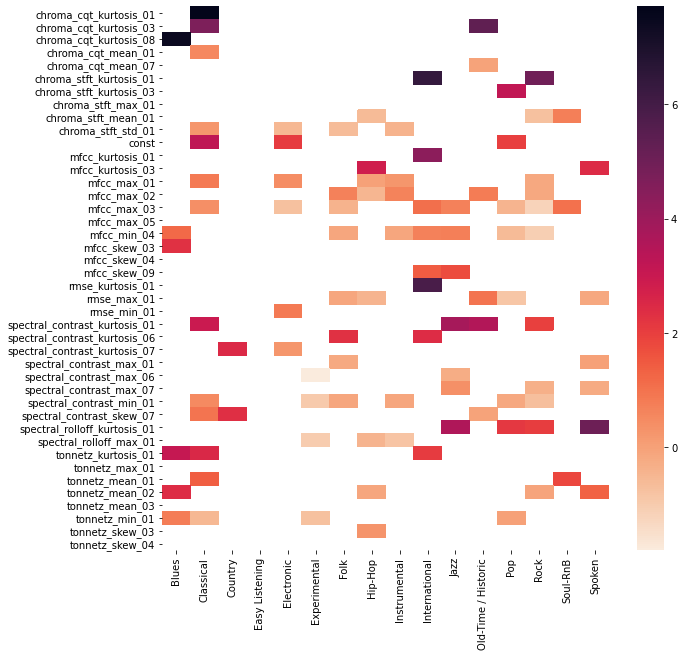

In [35]:
import seaborn as sns;

# Effect of positive coeffs
df_merged_pos = df_merged[df_merged>0]

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(np.log(df_merged_pos), cmap=sns.cm.rocket_r, ax=ax)

<AxesSubplot:>

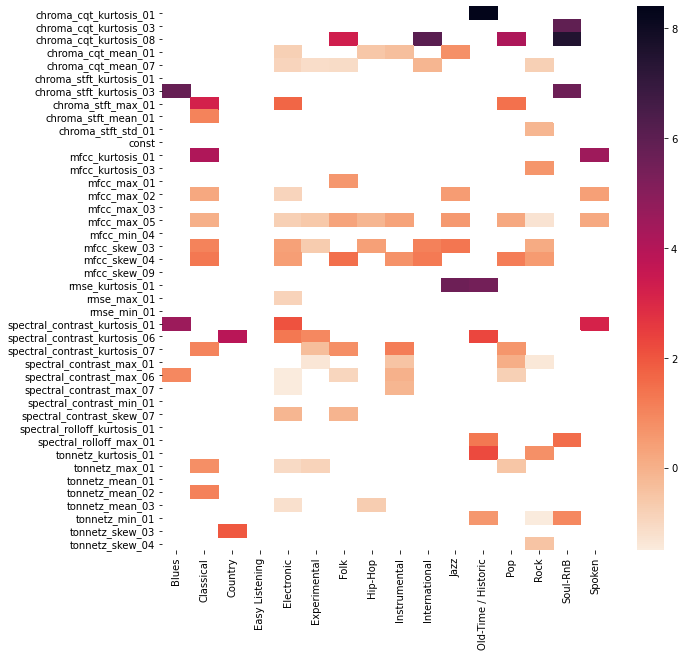

In [36]:
# Effect of negative coeffs
df_merged_neg = df_merged[df_merged<0]

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(np.log(abs(df_merged_neg)), cmap=sns.cm.rocket_r, ax=ax)

## Samples for questionnary

The survey is going to be run through CitizenScience Zurich platform:  
https://lab.citizenscience.ch/en/project/339/

In [107]:
min_max_scaler_q = preprocessing.MinMaxScaler()
feature_flatten_normalized = min_max_scaler_q.fit_transform(features_flatten)
feature_flatten_normalized = pd.DataFrame(feature_flatten_normalized)
feature_flatten_normalized.columns = features_flatten.columns
feature_flatten_normalized.index = features_flatten.index
feature_flatten_normalized.head()

chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        0.001033                 0.002501   
3                        0.000435                 0.000941   
5                        0.000281                 0.000649   
10                       0.000640                 0.000574   
20                       0.000199                 0.000606   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.001246                 0.001021   
3                        0.001300                 0.001243   
5                        0.000948                 0.000865   
10                       0.002340                 0.000649   
20                       0.001219                 0.000765   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        0.001067                 0.000873   
3                        0.001121                 0.000708   
5                        0.001210                 0.000997   
10                       0.001031                 0.001039   
20                       0.000845                 0.000714   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        0.000798                 0.001470   
3                        0.000771                 0.001047   
5                        0.000236                 0.000535   
10                       0.000865                 0.001189   
20                       0.000384                 0.000564   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  ...  \
track_id                                                    ...   
2                        0.003169                 0.002444  ...   
3                        0.002547                 0.002038  ...   
5                        0.003005                 0.002274  ...   
10                       0.002886                 0.002806  ...   
20                       0.002495                 0.001236  ...   

          tonnetz_std_04  tonnetz_std_05  tonnetz_std_06  zcr_kurtosis_01  \
track_id                                                                    
2               0.148243        0.130829        0.101443         0.000915   
3               0.177944        0.152235        0.150073         0.000568   
5               0.107253        0.135841        0.124322         0.001040   
10              0.210157        0.192545        0.117085         0.002773   
20              0.273332        0.241482        0.181304         0.002208   

          zcr_max_01  zcr_mean_01  zcr_median_01  zcr_min_01  zcr_skew_01  \
track_id                                                                    
2           0.454097     0.097468       0.079564    0.000000     0.189929   
3           0.461007     0.096271       0.071390    0.000000     0.185952   
5           0.368707     0.060433       0.046322    0.000000     0.191032   
10          0.446693     0.088225       0.080109    0.000000     0.205412   
20          0.464462     0.053726       0.044687    0.003724     0.201654   

          zcr_std_01  
track_id              
2           0.143937  
3           0.162532  
5           0.104805  
10          0.095226  
20          0.072089  

[5 rows x 518 columns]

In [108]:
features_genre_relevant = feature_flatten_normalized[tracks["track"]['genre_top'] == 'Pop'][df_merged.index[df_merged.index != 'const']]
    #if not math.isnan(df_merged.loc['const'][genre]):
     #   mult = features_genre_relevant * df_merged[genre] #+ df_merged.loc['const'][genre]
    #else:
mult = features_genre_relevant * df_merged['Pop'] 
pop_score_pred = mult.sum(axis=1) 

In [109]:
pop_score_pred[~no_album][tracks["track"]['genre_top'] == 'Pop']

track_id
10       -5.404185
213      -5.742983
821      -5.629483
822      -5.652588
823      -5.532414
            ...   
154410   -5.358343
154411   -5.563459
154412   -5.206557
154413   -5.894569
154414   -6.035722
Length: 2321, dtype: float64

In [88]:
genre_df_pred = pop_score_pred[~no_album][tracks["track"]['genre_top'] == 'Pop']
low, high = genre_df_pred.quantile([0.25,0.75])
pop_df_pred = genre_df_pred.loc[(genre_df_pred > high)]

In [89]:
pop_df_dataset = pop_df["pop_score"][tracks["track"]['genre_top'] == 'Pop'][pop_df["pop_score"][tracks["track"]['genre_top'] == 'Pop'] < 0]

In [90]:
tp = pop_df_dataset.index.intersection(pop_df_pred.index)
tp

Int64Index([  1645,   1648,   1649,   1658,   1662,   1691,   5175,   5177,
              5178,   5179,
            ...
            150024, 150026, 153366, 153368, 153372, 153373, 153382, 153424,
            153452, 154412],
           dtype='int64', name='track_id', length=229)

In [91]:
pop_df["pop_score"][tp].nsmallest(3)

track_id
89489   -2.112164
29161   -1.739491
40251   -1.682090
Name: pop_score, dtype: float64

In [40]:
def n_samples_genre(n, genre, high_score_threshold, low_score_threshold):
    print('Genre : ', genre)
    features_genre_relevant = feature_flatten_normalized[tracks["track"]['genre_top'] == genre][df_merged.index[df_merged.index != 'const']]
    mult = features_genre_relevant * df_merged[genre] 
    pop_score_pred = mult.sum(axis=1) 
    
    # The ones that are popular/unpopular based on the dataset
    pop_df_dataset = pop_df["pop_score"][tracks["track"]['genre_top'] == genre][pop_df["pop_score"][tracks["track"]['genre_top'] == genre] > 0]
    unpop_df_dataset = pop_df["pop_score"][tracks["track"]['genre_top'] == genre][pop_df["pop_score"][tracks["track"]['genre_top'] == genre] < 0]
    
    # The ones that are popular/unpopular based on the regression
    genre_df_pred = pop_score_pred[~no_album][tracks["track"]['genre_top'] == genre]
    low, high = genre_df_pred.quantile([0.25,0.75])
    pop_df_pred = genre_df_pred.loc[(genre_df_pred > high)]
    unpop_df_pred = genre_df_pred.loc[(genre_df_pred < low)]
    
    # True Positive
    tp = pop_df_dataset.index.intersection(pop_df_pred.index)
    tp = pop_df["pop_score"][tp].nlargest(1)
    print('TP')
    print(tp)
    
    # False Positive
    fp = unpop_df_dataset.index.intersection(pop_df_pred.index)
    fp = pop_df["pop_score"][fp].nsmallest(1)
    print('FP')
    print(fp)
    
    # True Negative
    tn = unpop_df_dataset.index.intersection(unpop_df_pred.index)
    tn = pop_df["pop_score"][tn].nsmallest(1)
    print('TN')
    print(tn)
    
    # False Negative
    fn = pop_df_dataset.index.intersection(unpop_df_pred.index)
    fn = pop_df["pop_score"][fn].nlargest(1)
    print('FN')
    print(fn)
    print("===============")
    
    return [tp, fp, tn, fn]

In [41]:
samples = []
#genres_survey = tracks["track"]['genre_top'].value_counts().index
genres_survey = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

for genre in genres_survey:
    samples.extend(n_samples_genre(1, genre, 0, 0))

Genre :  Electronic
TP
track_id
69170    4.443784
Name: pop_score, dtype: float64
FP
track_id
82185   -2.565108
Name: pop_score, dtype: float64
TN
track_id
1432   -2.92627
Name: pop_score, dtype: float64
FN
track_id
28553    3.518097
Name: pop_score, dtype: float64
Genre :  Experimental
TP
track_id
7391    2.683178
Name: pop_score, dtype: float64
FP
track_id
155010   -2.841336
Name: pop_score, dtype: float64
TN
track_id
42956   -3.034765
Name: pop_score, dtype: float64
FN
track_id
92296    2.858244
Name: pop_score, dtype: float64
Genre :  Folk
TP
track_id
50952    3.00961
Name: pop_score, dtype: float64
FP
track_id
154623   -2.002789
Name: pop_score, dtype: float64
TN
track_id
38439   -2.500617
Name: pop_score, dtype: float64
FN
track_id
88863    1.738048
Name: pop_score, dtype: float64
Genre :  Hip-Hop
TP
track_id
24425    4.373379
Name: pop_score, dtype: float64
FP
track_id
53996   -1.684636
Name: pop_score, dtype: float64
TN
track_id
53298   -2.298028
Name: pop_score, dtype: float64

## Samples creation helper

In [94]:
import shutil
samples = [str(sample.index.values[0]).zfill(6) for sample in samples]

for sample in samples:
    shutil.copyfile(f"{datasource}/fma_large/{sample[0:3]}/{sample}.mp3", f"{datasource}/survey_samples/{sample}.mp3")

# Survey analysis <a class="anchor" id="survey-analysis"></a>

For all of the 32 samples selected previously, participants are invited to answer to 3 questions after having listened to the corresponding 30s sample:
1. Would you like to listen to the rest of this music piece ?
1. Would you recommend this music piece to your friend ?
1. Would you be surprised to hear this piece in the radio ? 

For each of these questions, answers are collected on a five-level Likert scale proposing the following options:
- Definitely yes
- Yes
- I don't know
- No
- Definitely no

Only a couple of participants have taken part in this survey so far, hence no results can be drawn. However we already expose the analysis pipeline that we intend to use to investigate the results obtained through the survey. 

## Loading survey's data

In [120]:
# path to the folders hosting informations about the survey
PATH_SURVEY_FOLDER = "./Musicology/"
# general informations
TASK_FOLDER_ZIP = "339_music_popularity_task_csv.zip"
# participant's answers
TASK_RUN_FOLDER_ZIP = "339_music_popularity_task_run_csv.zip"

In [121]:
# zip with general informations
zf_task = ZipFile(PATH_SURVEY_FOLDER+TASK_FOLDER_ZIP)
# zip with answers
zf_task_run = ZipFile(PATH_SURVEY_FOLDER+TASK_RUN_FOLDER_ZIP)

In [122]:
# in the code, we'll refer to the above mentionned questions with the following labels
QUESTIONS = ["like", "recommend", "radio"]

### Create mapping from survey's identifiers to fma's one

In [123]:
# relink tasks id (samples in the survey) to track ids from fma dataset
df_task = pd.read_csv(zf_task.open('music_popularity_task.csv'))
df_task = df_task[["id", "info_filename", "n_answers"]]
df_task["info_filename"] = df_task["info_filename"].apply(lambda filemp3: int(filemp3[:-4]))
df_task.rename({"info_filename":"track_id"}, axis=1, inplace=True)
# create a dict -> {task id: track id}
dict_task_to_track = pd.Series(df_task.track_id.values,index=df_task.id).to_dict()

### Load participant's answers

In [124]:
df_survey = pd.read_csv(zf_task_run.open('music_popularity_task_run.csv'))
df_survey = df_survey[["id", "task_id", "user_id", "user_ip", "info_0", "info_1", "info_2"]]

# convert Likert scale to numerical values
convert_likert_scale = {"Definitely no":-2,
                        "No":-1,
                        "I don't know":0,
                        "Yes":1,
                        "Definitely yes":2
                       }
for col in df_survey.columns:
    if 'info' in col:
        df_survey[col] = df_survey[col].map(convert_likert_scale)

# rename column based on the questions asked
rename_columns = {"info_0":QUESTIONS[0], "info_1":QUESTIONS[1], "info_2":QUESTIONS[2]}
df_survey.rename(mapper=rename_columns, inplace=True, axis=1)

# retrieve track id (fma) from task id (CSZ)
df_survey["track_id"] = df_survey["task_id"].map(dict_task_to_track)

# create unique identifier for the user either based on IP or user id given by the platform
df_survey["user"] = [str(uid) if str(uid) != "nan" 
                       else str(uip) 
                       for uid, uip in zip(df_survey.user_id, df_survey.user_ip)
                      ]
df_survey.drop(["user_id", "user_ip"], axis=1, inplace=True)

df_survey.sample(5)

id  task_id  like  recommend  radio  track_id             user
43  167297   226334     1          0     -1      9520            229.0
7   167261   226346     2          1     -2     53298  192.172.189.251
10  167264   226352     0         -1     -1     69170  192.172.189.251
63  167317   226350     1          2     -2     62450            229.0
48  167302   226344     1          1     -1     50952            229.0

### Compute multi-level modeling variables

In [125]:
users_means = df_survey.groupby("user").mean()
users_means

id   task_id     like  recommend   radio     track_id
user                                                                        
192.172.189.251  167269.5  226347.5  0.34375    0.03125 -0.5000  64145.15625
229.0            167301.5  226347.5 -0.21875   -0.37500 -0.1875  64145.15625

In [126]:
for q in QUESTIONS:
    df_survey["rel_"+q] = [score-users_means.loc[user_id][q]
                             for (score, user_id) in zip(df_survey[q], df_survey["user"])
                            ]
    
df_survey.sample(5)

id  task_id  like  recommend  radio  track_id             user  \
46  167300   226340     1          1     -2     31720            229.0   
13  167267   226358    -2         -2      0     92296  192.172.189.251   
16  167270   226333     1          0      2      7391  192.172.189.251   
57  167311   226354    -2         -2      1     82185            229.0   
51  167305   226356     1          1     -1     88863            229.0   

    rel_like  rel_recommend  rel_radio  
46   1.21875        1.37500    -1.8125  
13  -2.34375       -2.03125     0.5000  
16   0.65625       -0.03125     2.5000  
57  -1.78125       -1.62500     1.1875  
51   1.21875        1.37500    -0.8125

### Enrich with fma and previously computed features

In [127]:
samples_id = [sample.index[0] for sample in samples]
additional_info = pop_df.loc[samples_id].drop("date_created", axis=1)

# retrieve type of classification (TP,FP,TN,FN) from the way samples were generated
additional_info["type"] = ["tp" if (i%4)==0
                           else "fp" if (i%4)==1
                           else "tn" if (i%4)==2
                           else "fn"
                           for i in np.arange(len(additional_info))
                          ]

# add these informations in the survey DF
df_survey = df_survey.merge(additional_info, on="track_id")
df_survey.sample(5)

id  task_id  like  recommend  radio  track_id             user  \
1   167296   226332    -2         -2      1      1432            229.0   
22  167265   226354    -1         -2     -1     82185  192.172.189.251   
55  167293   226359     1          1      2    114396            229.0   
7   167299   226338     1          1     -1     28553            229.0   
25  167305   226356     1          1     -1     88863            229.0   

    rel_like  rel_recommend  rel_radio   genre_top  listens  favorites  \
1   -1.78125       -1.62500     1.1875  Electronic       41          0   
22  -1.34375       -2.03125    -0.5000  Electronic       13          0   
55   1.21875        1.37500     2.1875        Rock    13620         30   
7    1.21875        1.37500    -0.8125  Electronic   128907        393   
25   1.21875        1.37500    -0.8125        Folk     4151          7   

    comments  album_listens  album_favorites  album_comments  pop_score type  
1          0             41                0               0  -2.926270   tn  
22         0            390                0               0  -2.565108   fp  
55         0         106338               29               7   2.514736   fn  
7         12         102484               10               1   3.518097   fn  
25         1          99511               10               2   1.738048   fn

## Results analysis

### Inter-rater agreement

In [189]:
participants_list = list(set(df_survey.user))

# should be unique so sum is just the score given by the rater
survey_grouped_user_track = df_survey.groupby(["user", "track_id"]).sum()

In [210]:
def dist_labels(l1, l2):
    return np.abs(l1-l2)

In [208]:
for q in QUESTIONS+["rel_"+q for q in QUESTIONS]:
    print("===============")
    print("Feature : ", q)

    taskdata = []
    for i, participant in enumerate(participants_list):
        taskdata = taskdata+[[i
                              ,str(samples_id[j])
                              ,survey_grouped_user_track.loc[participant][q].loc[samples_id[j]]
                             ]
                             for j in range(0,len(samples_id))
                            ]

    ratingtask = agreement.AnnotationTask(data=taskdata, distance=dist_labels)
    print("Agreement measures:")
    print("kappa : {0:.5g}".format(ratingtask.kappa()))
    print("fleiss : {0:.5g}".format(ratingtask.multi_kappa()))
    print("alpha : {0:.5g}".format(ratingtask.alpha()))
    print("scotts : {0:.5g}".format(ratingtask.pi()))

Feature :  like
Agreement measures:
kappa : -0.277
fleiss : -0.277
alpha : 0.30859
scotts : -0.34988
Feature :  recommend
Agreement measures:
kappa : -0.04474
fleiss : -0.04474
alpha : 0.41244
scotts : -0.076636
Feature :  radio
Agreement measures:
kappa : -0.44934
fleiss : -0.44934
alpha : 0.18294
scotts : -0.53342
Feature :  rel_like
Agreement measures:
kappa : 0.078125
fleiss : 0.078125
alpha : 0.39393
scotts : -0.058296
Feature :  rel_recommend
Agreement measures:
kappa : 0.080078
fleiss : 0.080078
alpha : 0.36065
scotts : -0.045505
Feature :  rel_radio
Agreement measures:
kappa : -0.1875
fleiss : -0.1875
alpha : 0.19036
scotts : -0.37324


### Correlation analysis

In [211]:
def corr_sig(df):
    """ return matrix of p values of df based on its correlation matrix """
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

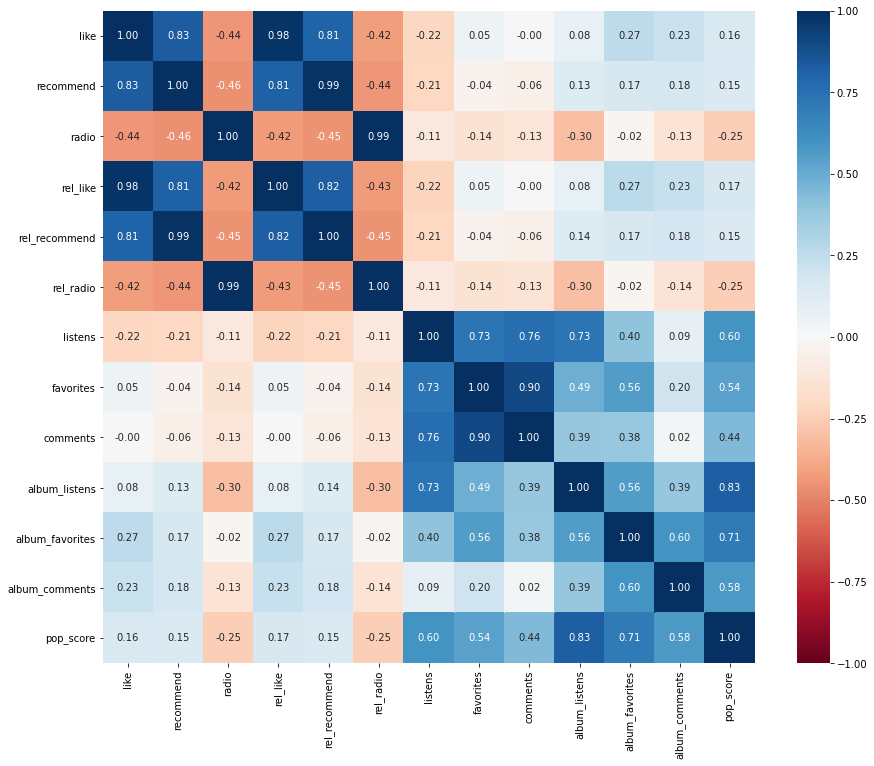

In [216]:
df_survey_pop = df_survey[QUESTIONS
                          +["rel_"+q for q in QUESTIONS]
                          +POP_FEATURES
                          +["album_"+f for f in POP_FEATURES]
                          +["pop_score"]
                         ]

corr_survey = df_survey_pop.corr()

p_values = corr_sig(df_survey_pop) # compute p-values
mask_sig = np.invert(np.tril(p_values<0.05)) # mask non significant correlations

fig, ax = plt.subplots(figsize=(15,12))
ax = sns.heatmap(corr_survey
                 #, mask=mask_sig # mask non significant values
                 , square=True
                 , annot=True
                 , fmt=".2f"
                 , vmin=-1
                 , vmax=1
                 , cmap="RdBu"
                )
plt.show()

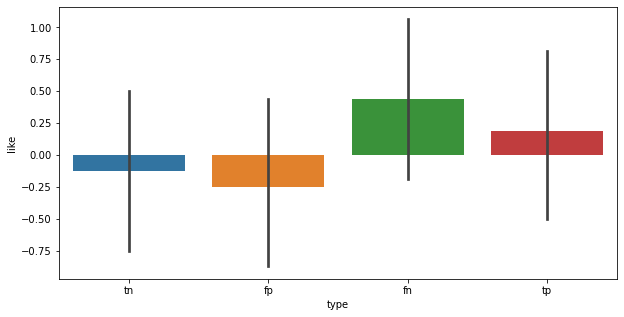

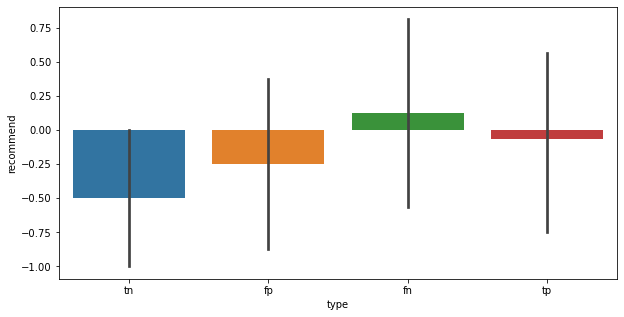

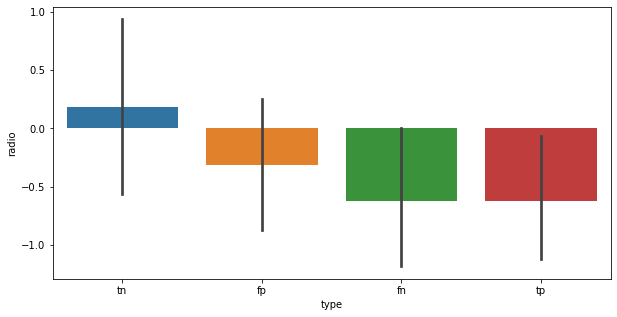

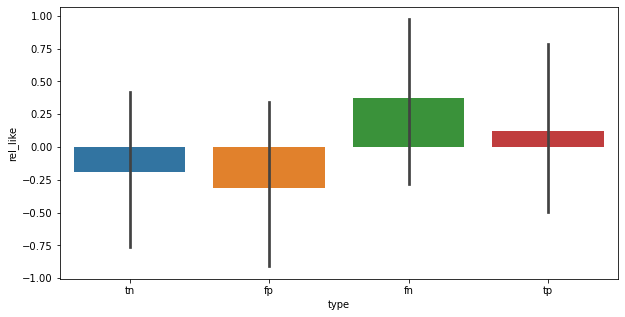

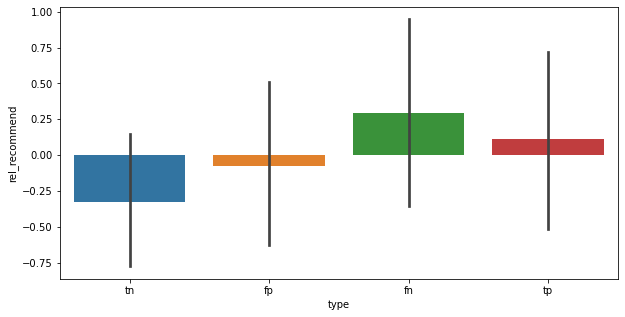

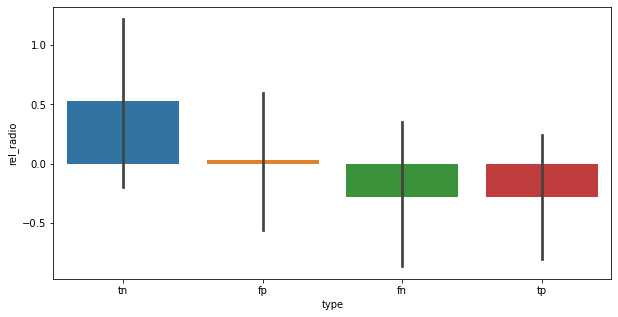

In [217]:
for category in QUESTIONS+["rel_"+q for q in QUESTIONS]:
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x="type", y=category, data=df_survey)

# Explaining the linear regression model of popularity score using audioLIME <a class="anchor" id="audiolime"></a>

We will use the approach presented in the preprint paper: [Haunschmid et al. (2020) "audioLIME: Listenable Explanations Using Source Separation"](https://arxiv.org/abs/2008.00582)

This approach will allow us to generate "listenable" explainations of the music - which parts of the music piece increase and which decrease the assigned score

In [95]:
# Feature computation code cloned from FMA repository (features.py)

def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    # More efficient to slice if indexes are sorted.
    return columns.sort_values()

def compute_features(x):
    features = pd.Series(index=columns(), dtype=np.float32)

    def feature_stats(name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)

    sr = 44100

    x = librosa.to_mono(x)
    f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
    feature_stats('zcr', f)

    cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                              n_bins=7*12, tuning=None))
    assert cqt.shape[0] == 7 * 12
    assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

    f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
    feature_stats('chroma_cqt', f)
    f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
    feature_stats('chroma_cens', f)
    f = librosa.feature.tonnetz(chroma=f)
    feature_stats('tonnetz', f)

    del cqt
    stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
    assert stft.shape[0] == 1 + 2048 // 2
    assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1
    del x

    f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
    feature_stats('chroma_stft', f)

    f = librosa.feature.rms(S=stft)
    feature_stats('rmse', f)

    f = librosa.feature.spectral_centroid(S=stft)
    feature_stats('spectral_centroid', f)
    f = librosa.feature.spectral_bandwidth(S=stft)
    feature_stats('spectral_bandwidth', f)
    f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
    feature_stats('spectral_contrast', f)
    f = librosa.feature.spectral_rolloff(S=stft)
    feature_stats('spectral_rolloff', f)

    mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    del stft
    f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
    feature_stats('mfcc', f)

    # except Exception as e:
    #     print('{}: {}'.format(tid, repr(e)))

    return features

### For audioLIME to work, we need to repare one function which:
* takes a raw soundwave input
* computes the librosa feature set for the input
* selects the significant features, propagates them through regression model
* takes the result and makes it classification output

In [149]:
# p: Minimum deviation from dist mean which changes classification outcome
# Higher value gives better results but requires much more samples to be
# processed in order to find distortions which "flip" the class.
p = 0.25

def predict_fn(xs):
    res = []
    # TODO: parallelize this if possible
    for x in xs:
        feat_comp = pd.DataFrame([compute_features(x)])
        feat_comp.columns = ['_'.join(col) for col in feat_comp.columns.values]
        feat_comp = feat_comp[selected_features].values[0]
        feat_comp_scaled = min_max_scaler.transform(feat_comp.reshape(1, -1))
        feat_comp_scaled = pd.DataFrame(feat_comp_scaled)
        feat_comp_scaled.insert(0, 'const', 1.0)
        score = results.predict(feat_comp_scaled).values[0]
        #return np.array([score])
        if score > p: # Popular
            res.append(np.array([0, 0, 1]))
        elif score < -p: # Unpopular
            res.append(np.array([1, 0, 0]))
        else: # Average
            res.append(np.array([0, 1, 0]))
        pbar.update(1)
    return np.array(res)

### Testing the function

In [150]:
pbar = tqdm(total=2)

x_local, _ = librosa.load(f"{datasource}/fma_large/037/037111.mp3", sr=None, mono=True)
print(predict_fn(np.array([x_local, x_local])))

pbar.close()

/home/mbien/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[[0 1 0]
 [0 1 0]]



### Processing the file using audioLIME

In [ ]:
# Number of distortion tries, the more the better
num_samples = 1024

# ID of the audio sample
audio_id = 37111

pbar = tqdm(total=num_samples)

audio_str = str(audio_id).zfill(6)
audio_path = f"{datasource}/fma_large/{audio_str[:3]}/{audio_str}.mp3"

data_provider = RawAudioProvider(audio_path)

# We split into 3s samples
spleeter_factorization = SpleeterFactorization(data_provider,
                                                n_temporal_segments=10,
                                                composition_fn=None,
                                                model_name='spleeter:5stems')

explainer = lime_audio.LimeAudioExplainer(verbose=True, absolute_feature_sort=False)

explanation = explainer.explain_instance(factorization=spleeter_factorization,
                                          predict_fn=predict_fn,
                                          top_labels=1,
                                          num_samples=num_samples,
                                          batch_size=16
                                          )

pbar.close()

/home/mbien/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


INFO:tensorflow:Apply unet for vocals_spectrogram
INFO:tensorflow:Apply unet for piano_spectrogram
INFO:tensorflow:Apply unet for drums_spectrogram
INFO:tensorflow:Apply unet for bass_spectrogram
INFO:tensorflow:Apply unet for other_spectrogram
INFO:tensorflow:Restoring parameters from pretrained_models/5stems/model


/home/mbien/.local/lib/python3.8/site-packages/audioLIME/factorization.py:84: UserWarning: last 4 samples are ignored
  warnings.warn("last {} samples are ignored".format(audio_length - explained_length))


### Let's check if we have enough samples, and proceed

In [146]:
labels = sorted(list(explanation.local_exp.keys()))
rlabel = ["unpopular", "average", "popular"]


for label in labels:
    top_components, component_indeces = explanation.get_sorted_components(label,
                                                                        positive_components=True,
                                                                        negative_components=False,
                                                                        num_components=3,
                                                                        return_indeces=True)
    print(f"Label {rlabel[label]}: {len(top_components)} components found")

Label average: 3 components found


### Write the original music file and explainations to the `output` folder

In [131]:
!rm -rf output
!mkdir -p output

for label in labels:
    top_components, component_indeces = explanation.get_sorted_components(label,
                                                                        positive_components=True,
                                                                        negative_components=False,
                                                                        num_components=3,
                                                                        return_indeces=True)

  #print(top_components)
    if len(top_components) > 0:
        sf.write(os.path.join("output", f"explanation_{rlabel[label]}.wav"), sum(top_components), 16000)
sf.write(os.path.join("output", "original.wav"), spleeter_factorization.data_provider.get_mix(), 16000)

In [147]:
# play the most important components of the original song
exp, sr = librosa.load("output/original.wav", sr=None, mono=False)

display.Audio(data=exp, rate=sr)

In [133]:
# play the "unpopular" explaination
exp, sr = librosa.load("output/explanation_unpopular.wav", sr=None, mono=True)

display.Audio(data=exp, rate=sr)

In [148]:
# play the "average" explaination
exp, sr = librosa.load("output/explanation_average.wav", sr=None, mono=True)

display.Audio(data=exp, rate=sr)

In [132]:
# play the "popular" explaination
exp, sr = librosa.load("output/explanation_popular.wav", sr=None, mono=True)

display.Audio(data=exp, rate=sr)

# Efforts to use Wav2Vec2.0 for popularity estimation <a class="anchor" id="wave2vec"></a>

## Loading the dataset

To run this code, you must have an undersampled version of `fma_large` dataset, which can be created using the code from [milestone3-wav2vec2.ipynb](https://github.com/Glorf/DH-401/blob/main/milestone3-wav2vec2.ipynb)

In [92]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, max_length=480000)
min_train = -3.3939661205367715
max_train = 5.098214985136099

class PopularityDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        track_id = str(int(row.track_id)).zfill(6)
        audio_sample, _ = torchaudio.load(f"{datasource}/musicology-dataset-downsampled/{track_id}.mp3")
        audio_sample = torch.mean(audio_sample, dim=0, keepdim=True)
        audio_sample = audio_sample.squeeze().numpy()
        audio_sample = feature_extractor(audio_sample, sampling_rate=16000, return_tensors="pt", padding='max_length', max_length=480000).input_values
        #score = (row.pop_score - min_train)/(max_train-min_train)
        return {
            "input_ids": audio_sample.flatten()[:480000],
            "labels": torch.tensor(row.pop_score).float(),
        }

# Ensure we are using the same split as the one used for finetuning
test = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/dh-401/pop_test.csv")

test_ds = PopularityDataset(test[:10])
test.head()

track_id  pop_score
0    147246   0.361502
1     15577  -0.022418
2    127407  -0.745016
3    131643   1.275226
4    116637  -0.683588

## Setup model architecture and load it from the hub
Only difference compared to the training code is no Dropout

In [90]:
class Wav2Vec2ForAudioClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.wav2vec2 = Wav2Vec2Model(config)
        self.dropout = nn.Dropout(0)
        self.classifier = nn.Linear(768, 1)

        self.init_weights()

    def forward(self, input_ids):
        outputs = self.wav2vec2(
            input_ids,
            output_attentions=True,
            output_hidden_states=True
        )
        pooled_output = outputs.last_hidden_state[:,0,:]

        return self.classifier(pooled_output)

model = Wav2Vec2ForAudioClassification.from_pretrained("mbien/fma2vec2popularity").to("cuda")

In [91]:
test_dl = DataLoader(test_ds)

for sample in test_dl:
    model.eval()
    out = model(sample["input_ids"].to("cuda"))
    print("Original:", sample["labels"].item(), "Predicted:", out)

Original: 0.3615018427371979 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.02241761051118374 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.7450163960456848 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: 1.275226354598999 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.6835883855819702 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: 0.2886952757835388 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -1.2600702047348022 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.020840361714363098 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.7316892147064209 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: 1.057540774345398 Predicted: tensor([[-0.1074]], device='cuda:0'

## Is this just a very expensive average number calculator?
We tested also:
* variable size and amount of output layers
* classification output with variable number of classes
* pooled output as average of all the units of last hidden layers instead of only first unit
* other architecture modifications such as more dropouts, different activation functions

None of this options allowed to fine-tune the model with performance above average.  
### Our guesses about why this didn't work: